In [73]:


import numpy as np
from scipy.optimize import curve_fit, root, root_scalar
from matplotlib import pyplot as plt
from math import erf

rho_b=810
M_w=18.001528e-3 # molar mass of water
M_a=28.9647e-3 # molar mass of air
R=8.314462618 # universal gas constant
k_B=1.380649e-23 # Boltzmann constant
N_a=6.02214076e23 # Avogadro constant
L_s=2.834e6 # J/kg latent heat of sublimation
# thermal conductivity of moist air
K = 0.024 # W/m/K
cp = 1005 # J/kg/K specific heat capacity of air at constant pressure
beta_d=1.0 # thermal accommodation coefficient

alpha_d=0.5 # deposition coefficient

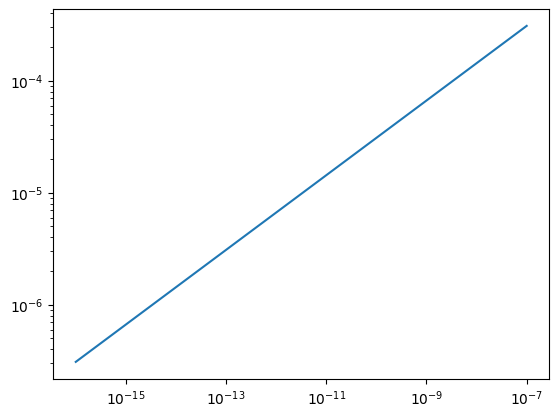

In [74]:
def c_a(m):
    m_t = 2.146e-1 # transition mass
    alpha = np.where(m<m_t,526.1,0.04142)
    beta = np.where(m<m_t,3.0,2.2)
    
    return np.where(m<m_t,0.99999999,np.sqrt(np.sqrt(27)*rho_b/(8*alpha**(3/beta)))*m**((3-beta)/(2*beta)))


def e_prolate(m):
    return (1 - 1/np.astype(c_a(m),complex) ** 2)**0.5

def L(m):
    return 2* (m / (rho_b * 4 / 3 * np.pi * c_a (m))) ** (1 / 3)

def C(m):
    # capacitance of spheroid
    e = e_prolate(m) # eccentricity
    return (L(m) * e / (np.log((1 + e) / (1 - e)))).real

def A(m):
    # surface area of spheroid
    e = e_prolate(m)

    return np.where(e > 0, 0.5 * np.pi * L(m) ** 2 * (1 + c_a(m) / e * np.arcsin(e)), np.pi * L(m) ** 2).real



mass=np.logspace(-16,-7,1000)
e_prolate(mass)
plt.loglog(mass, C(mass))
# 
# plt.loglog(m,c_a(m)*D(m)/2)

In [75]:
def mu_air(T):
    sigma_air = 3.617e-10 # m
    Tstar = T/97.0
    Omega = 1.16145*Tstar**-0.14874+0.52487*np.exp(-0.77320*Tstar)+2.16178*np.exp(-2.43787*Tstar)
    return 5/(16*np.pi**0.5)*(M_a/N_a*k_B*T)**0.5/(sigma_air**2*Omega)

print(mu_air(298.15))

def psat_water(p, T):
    ew = np.exp(-6096.9385 / T + 21.2409642 - 2.711193e-2 * T + 1.673952e-5 * T ** 2 + 2.433502 * np.log(T))
    fw = 1.0016 + 3.15e-8 * p - 7.4e-4 / p
    return ew * fw


def psat_ice(p, T):
    ei = np.exp(-6024.528211 / T + 29.32707 + 1.0613868e-2 * T + -1.3198825e-5 * T ** 2 - 0.49382577 * np.log(T))
    fi = 1.0016 + 3.15e-8 * p - 7.4e-4 / p
    return ei * fi

def D_v(p,T):
    return 2.11e-5*(T/273.15)**1.94*(101325/p)


1.8361244967511803e-05


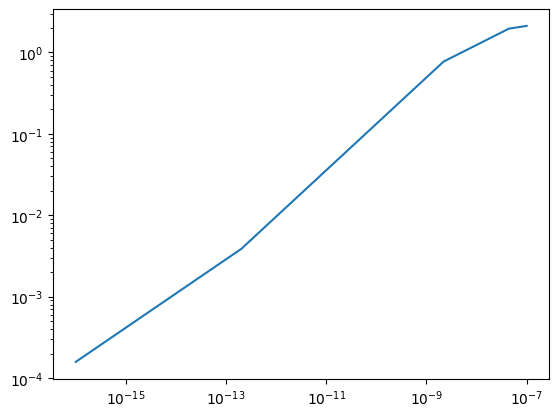

In [76]:
def u_terminal(m,p,T):
    m1=2.146e-13
    m2=2.166e-9
    m3=4.264e-8

    gamma_choices = [735.4, 59000, 329.8, 8.8] # 63292.4
    delta_choices = [0.42, 0.57, 0.31, 0.096]
    conditions = [m <= m1, (m > m1) & (m <= m2), (m > m2) & (m <= m3), m >= m3]

    gamma = np.select(conditions, gamma_choices)
    delta = np.select(conditions, delta_choices)

    c = (p/30000)**-0.178*(T/233)**-0.394
    return c*gamma * m**delta

plt.loglog(mass,u_terminal(mass,21000,200))

    

In [77]:

def f1(T_s,p,T,m,Sc,Re):
    rstar = A(m)/(4*np.pi*C(m))
    lstar_M = 2*np.pi*M_w/(R*T_s)*D_v(p,T)*f2(Sc,Re)/(2*alpha_d/(2-alpha_d))
    
    return 1#rstar/(rstar+lstar_M)

def u_r(T):
    return np.sqrt(2*k_B*T/(np.pi*M_a/N_a))

def f1star(p,T,m,Pr,Re):
    rho_a=p*M_a/(R*T)
    rstar = A(m)/(4*np.pi*C(m))
    lstar_Q = K*f2(Pr,Re)/(rho_a**(1/4)*u_r(T)*beta_d*cp)
    return 1#rstar/(rstar+lstar_Q)
    
def f2(N1, N2):
    a = N1 ** (1 / 3) * N2 ** (1 / 2)
    return 1#1+0.14*a**2 if a<=1 else 0.86+0.28*a

In [78]:
class Lognormal:
    def __init__(self,N,mu,sigma):
        self.N = N
        self.mu = mu
        self.sigma = sigma
    def pdf(self,x):
        return self.N/(x*np.log(self.sigma)*np.sqrt(2*np.pi))*np.exp(-(np.log(x/self.mu))**2/(2*np.log(self.sigma)**2))
    def cdf(self,x):
        return self.N/2*(1+np.array(list(map(erf, (np.log(x/self.mu))/(np.log(self.sigma)*np.sqrt(2))))))
    

In [79]:
def mass_flux_ice(T,p,rho_w,m,T_s):
 
    rho_a=p*M_a/(R*T) # density of air
    Sc=mu_air(T)/rho_a/D_v(p,T) # Schmidt number
    Re= rho_a * L(m) * u_terminal(m, p, T) / mu_air(T)
    
    # T_s is given, p_s is psat(T_s), rho_s is derived
    rho_w_surf = psat_ice(p,T_s)*M_w/(R*T_s)
    
    return 4*np.pi*C(m)*D_v(p,T)*f1(T_s,p,T,m,Sc,Re)*f2(Sc,Re)*(rho_w-rho_w_surf)

def heat_flux_ice(T,p,rho_w,m,T_s):
    rho_a=p*M_a/(R*T) # density of air
    Pr=mu_air(T)*cp/K # Prandtl number
    Re_thermal= rho_a * u_terminal(m,p,T) * L(m) / mu_air(T)
    for i in range(2):
        lstar_Q = K*f2(Pr,Re_thermal)/(rho_a**(1/4)*u_r(T)*beta_d*cp)
        Re_thermal=rho_a*u_terminal(m,p,T)*lstar_Q/mu_air(T)
    
    return 4*np.pi*C(m)*D_v(p,T)*f1star(p,T,m,Pr,Re_thermal)*f2(Pr,Re_thermal)*(T_s-T)

In [80]:
def flux_fun(T_s,p,T,rho_w,m):
    rho_a=p*M_a/(R*T) # density of air
    Sc=mu_air(T)/rho_a/D_v(p,T) # Schmidt number
    Re_mass= rho_a * L(m) * u_terminal(m, p, T) / mu_air(T)
    Pr=mu_air(T)*cp/K # Prandtl number
    Re_thermal= rho_a * u_terminal(m,p,T) * L(m) / mu_air(T)
    x=0
    while (Re_thermal-x)/Re_thermal>1e-4:
        x=Re_thermal
        lstar_Q = K*f2(Pr,Re_thermal)/(rho_a**(1/4)*u_r(T)*beta_d*cp)
        Re_thermal=rho_a*u_terminal(m,p,T)*lstar_Q/mu_air(T)
    
    rho_w_surf=psat_ice(p,T_s)/(R/M_w*T_s)
    
    return L_s*f1(T_s,p,T,m,Sc,Re_mass)*f2(Sc,Re_mass)*(rho_w-rho_w_surf)+f1star(p,T,m,Pr,Re_thermal)*f2(Pr,Re_thermal)*(T-T_s)



print(flux_fun(223,21750,200,0.3*1e-4,3e-10))

-44.52752732719491


1.219825819416452e-05
1.3346007272746298e-05
1.3900872604648948e-05
1.4444142200229362e-05


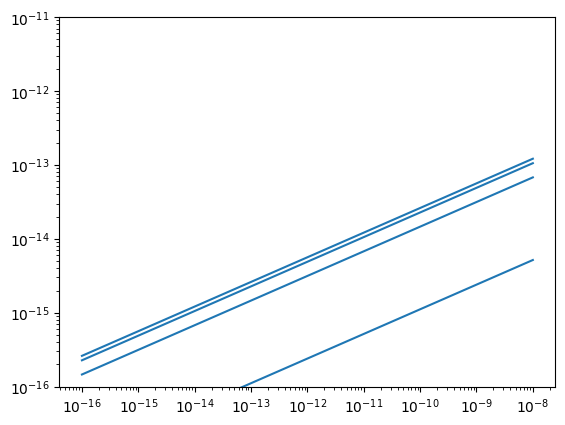

In [81]:
p=30000
m_vals = np.logspace(-16,-8,200)

ml=2.2e-10
m_fit = np.logspace(-14,-10,200)
y_fit=np.zeros_like(m_fit)

for T in [180,200,210,220]:
    y_numeric=np.zeros_like(m_vals)
    rho_w=psat_water(p,T)/(R/M_w*T)
    print(mu_air(T))

    def fit_fun(a,b):
        def f(m,m0,gamma,delta):
            return np.where(m<ml,1-np.exp(-(m/m0)**gamma),(m/ml)**delta)*a*m**b
        return f
    
    def fit_fun_koenig(m,a,b):
        return a*m**b
    
    for i,m in enumerate(m_vals):
        T_s=root_scalar(flux_fun, bracket=[T,T*1.1], args=(p, T, rho_w, m)).root
        y_numeric[i]=mass_flux_ice(T,p,rho_w,m,T_s)
    
    for i,m in enumerate(m_fit):
        T_s=root_scalar(flux_fun, bracket=[T,T*1.1], args=(p, T, rho_w, m)).root
        y_fit[i]=mass_flux_ice(T,p,rho_w,m,T_s)
    
    a,b = curve_fit(fit_fun_koenig,m_fit,y_fit,p0=(4e-13,0.173))[0]#,1e-15,0.22,0
    m0,gamma,delta = curve_fit(fit_fun(a,b),m_vals,y_numeric,p0=(1e-15,0.22,0.06),bounds=((0,0.2,0.05),(1e-8,0.25,0.2)))[0]
    
    plt.loglog(m_vals,y_numeric,label='numeric',color='C0')
    # plt.loglog(m_vals,fit_fun(a,b)(m_vals,m0,gamma,delta),'--',label='fit',color='C1')
    # plt.loglog(m_vals,fit_fun_koenig(m_vals,a,b),'--',label='fit Koenig',color='C2')

plt.ylim(1e-16,1e-11)
plt.show()
